In [9]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

In [10]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 15

In [11]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [12]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

2024-04-19 17:39:02.339733: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


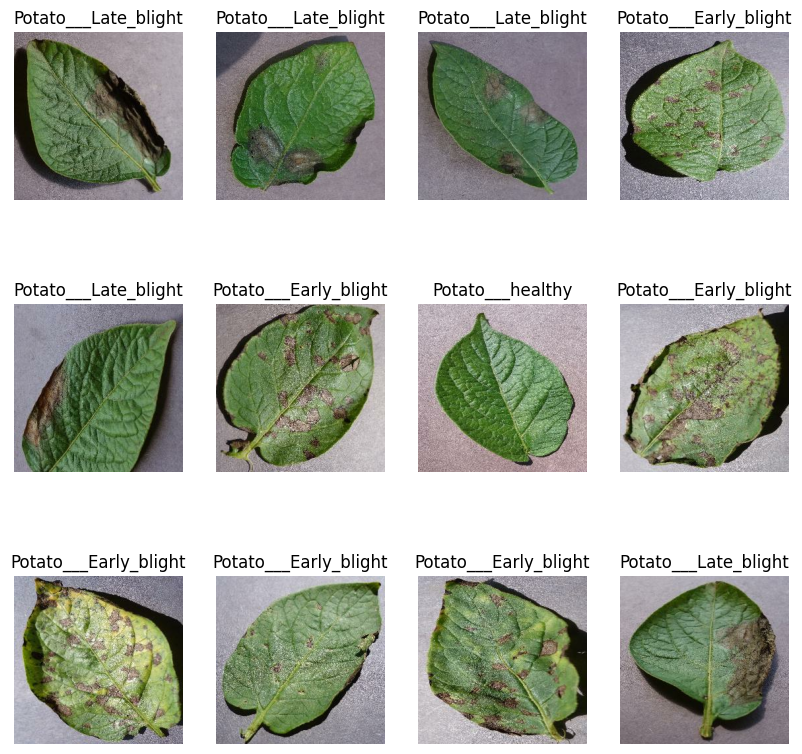

In [5]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.axis("off")
        plt.title(class_names[label_batch[i]])

In [6]:
len(dataset)

68

In [7]:
# 80% ==> Training
# 20% ==> 10% ==> Testing, 10% ==> Validation

In [8]:
# Task : Create a function for splitting Training set, Testing set and Validation set
def dataset_split(ds, test_size=0.2, validation_size=0.1, shuffle=True, shuffle_size=1000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=101)

    train_size = int(len(ds)*(1-test_size))
    validation_size = int(len(ds)*validation_size)
    train_ds = ds.take(train_size)
    validation_ds = ds.skip(train_size).take(validation_size)
    test_ds = ds.skip(train_size).skip(validation_size)

    return train_ds, validation_ds, test_ds

In [9]:
train_ds, validation_ds, test_ds = dataset_split(dataset, test_size=0.2, validation_size=0.1)

len(train_ds), len(validation_ds), len(test_ds)

(54, 6, 8)

In [10]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
validation_ds = validation_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = tf.keras.Sequential([
    resize_and_rescale,
    data_augmentation,

    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),

    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax')

])

model.build(input_shape=input_shape)

/windows/Desktop/AI-ML/Deep Learning/Potato_Disease_Project/venv/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [14]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 254, 254, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 127, 127, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 125, 125, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 62, 62, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 60, 60, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 30, 30, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (32, 28, 28, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (32, 14, 14, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (32, 12, 12, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (32, 6, 6, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (32, 4, 4, 64)         │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (32, 2, 2, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 256)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 64)               │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 3)                │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 183,747 (717.76 KB)

 Trainable params: 183,747 (717.76 KB)

 Non-trainable params: 0 (0.00 B)

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics = ['accuracy']
)

In [16]:
history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=validation_ds
)

Epoch 1/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 145s 3s/step - accuracy: 0.4436 - loss: 0.9447 - val_accuracy: 0.6786 - val_loss: 0.6933
Epoch 2/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 137s 2s/step - accuracy: 0.7834 - loss: 0.5183 - val_accuracy: 0.7857 - val_loss: 0.4993
Epoch 3/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 139s 2s/step - accuracy: 0.8236 - loss: 0.4089 - val_accuracy: 0.8274 - val_loss: 0.3586
Epoch 4/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 131s 2s/step - accuracy: 0.8837 - loss: 0.3002 - val_accuracy: 0.8690 - val_loss: 0.3903
Epoch 5/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.8880 - loss: 0.2838 - val_accuracy: 0.8929 - val_loss: 0.2601
Epoch 6/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.9072 - loss: 0.2329 - val_accuracy: 0.8929 - val_loss: 0.3086
Epoch 7/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9145 - loss: 0.2068 - val_accuracy: 0.9167 - val_loss: 0.2309
Epoch 8/15
54/54 ━━━━━━━━━━━━━━━━━━━━ 129s 2s/step - accuracy: 0.9254 - loss: 0.2088 - val_accuracy: 0.8631 - v

In [17]:
scores = model.evaluate(test_ds)
scores

8/8 ━━━━━━━━━━━━━━━━━━━━ 12s 698ms/step - accuracy: 0.9718 - loss: 0.0757


[0.08995910733938217, 0.96875]

In [18]:
history

In [19]:
history.params

{'verbose': 1, 'epochs': 15, 'steps': 54}

In [20]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [21]:
len(history.history['accuracy']), len(history.history['loss']), len(history.history['val_accuracy']), len(history.history['val_loss'])

(15, 15, 15, 15)

In [22]:
accuracy = history.history['accuracy']
loss = history.history['loss']
val_accuracy = history.history['val_accuracy']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

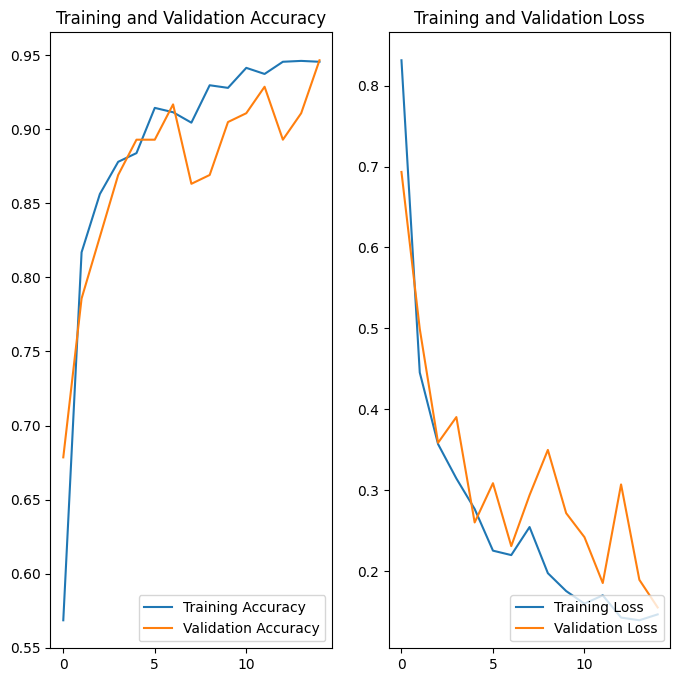

In [23]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), accuracy, label='Training Accuracy')
plt.plot(range(EPOCHS), val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='lower right')
plt.title('Training and Validation Loss')

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Potato___Early_blight


2024-04-19 18:13:03.908336: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


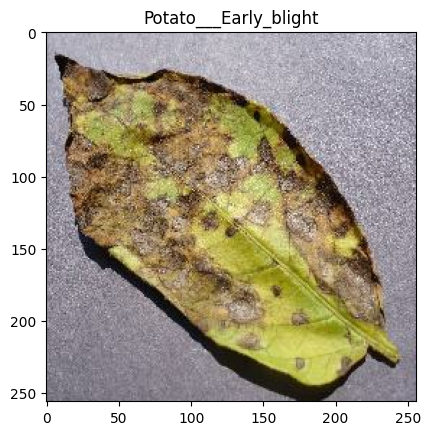

In [24]:

for image_batch, label_batch in test_ds.take(1):
    first_image = image_batch[6].numpy().astype('uint8')
    first_label = class_names[label_batch[6]]

    predicted_labels = model.predict(image_batch)
    print(class_names[np.argmax(predicted_labels[6])])

    plt.imshow(first_image)
    plt.title(first_label)

In [5]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


2024-04-19 18:13:14.850351: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


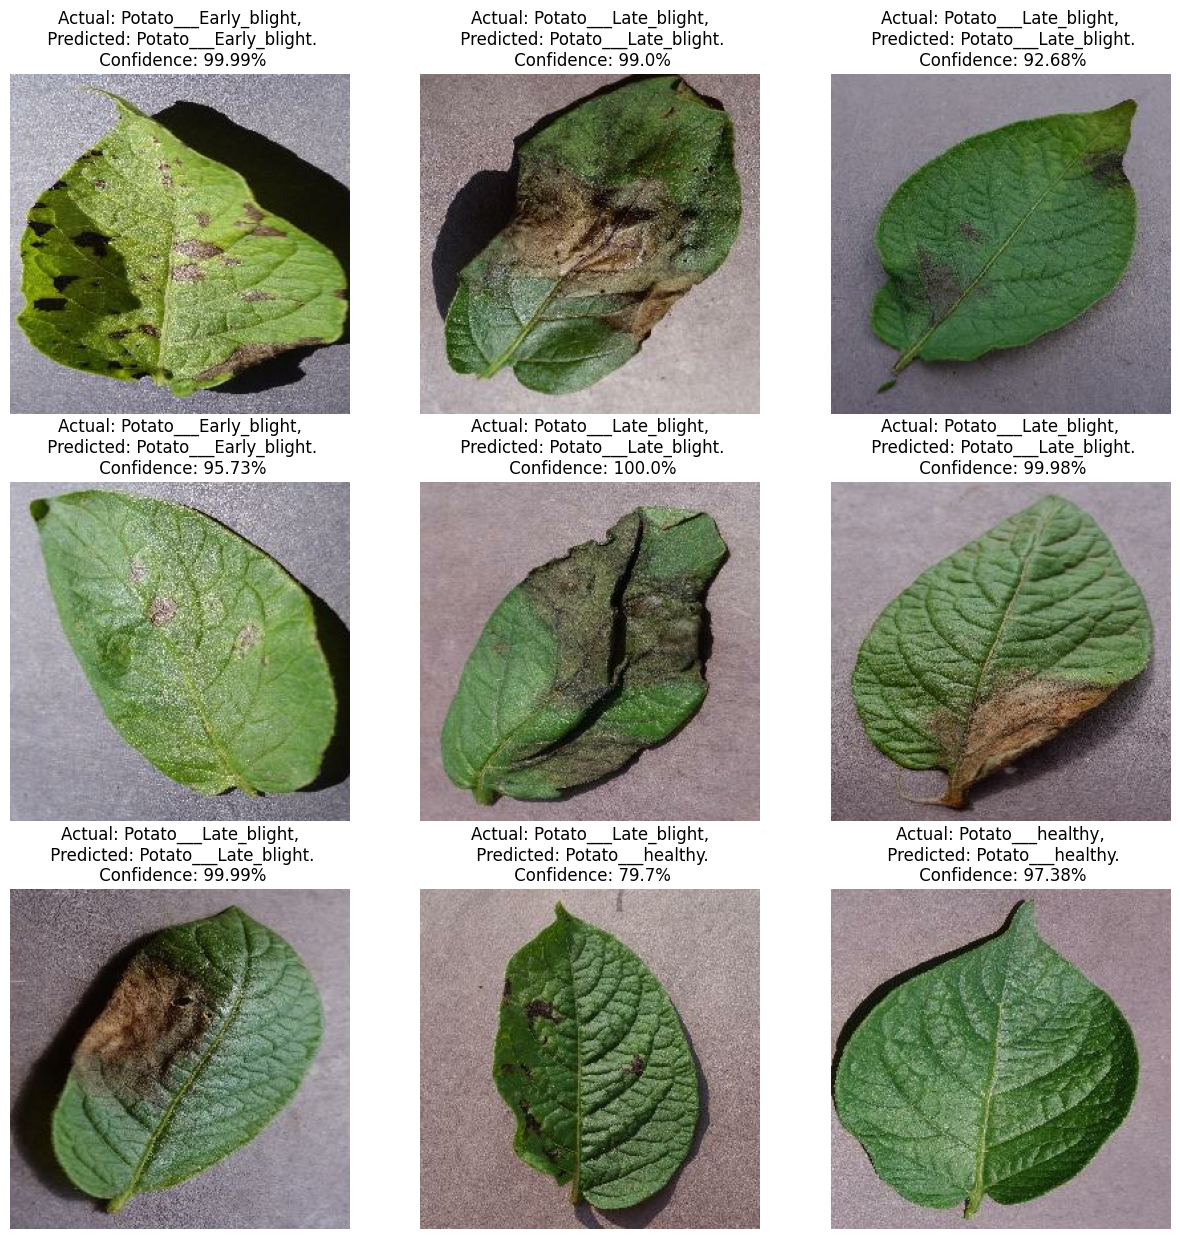

In [26]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [27]:
model_version=1
model.save(f"../models/v{model_version}.keras")

In [28]:
image = plt.imread('/windows/Desktop/AI-ML/Deep Learning/Potato_Disease_Project/early-blight-potatoes.jpg')
predicted_class, confidence = predict(model, image)
predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step


('Potato___Early_blight', 83.43)